# Learning rate finder

During the training of neural networks, one of the most important hyperparameters, and which largely influences the convergence of the latter, is the learning rate. Choosing a good learning rate is not a simple task, and it is often done using a grid search. However, this can take a long time, especially if the network is very large.

In his paper "[Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf)", Leslie Smith presented a method for finding a good learning rate for the majority of gradient based optimizers.

This method consists in starting the training of the network with a very small learning rate (10-8 for example), and increasing it exponentially with each mini-batch, until reaching a large value (1 or 10), or until the loss diverges (practically, we stop the loop if the loss reached is 4 or 5 times greater than the minimum loss we obtained).

At the end of the loop, a learning rate is chosen in the region where the loss was minimal. In practice, we take a value an order of magnitude smaller than the one that gave the minimum loss, a value that is always aggressive (to train quickly) but that remains safe in case of an explosion.

In the following, we will demonstrate the usefulness of this method by using an implementation of this method that we have done. You can find this implementation [here](https://github.com/pvnieo/My-Algorithm-Zoo/blob/master/Learning%20rate%20finder/lr_finder.py).

## Demo time

First of all, let's start by importing the necessary packages.

In [0]:
# stdlib
import time
import warnings
import copy
from collections import defaultdict
# 3p
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# project
from lr_finder import LRFinder

warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2
%matplotlib inline

For this demonstration, we will use the MNIST dataset, and we will implement a very simple neural network using pytorch. 

First of all, we define the data loaders and the transformations we will use later.

In [0]:
batch_size_train = 64
batch_size_test = 1000
## creating dataloaders
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                             torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize(
                               (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

val_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
dataloaders = {"train": train_loader, "val": val_loader}

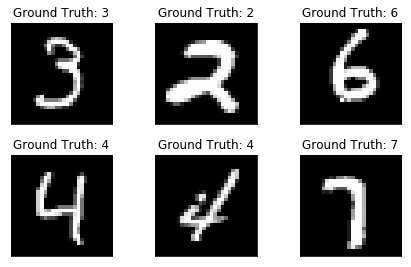

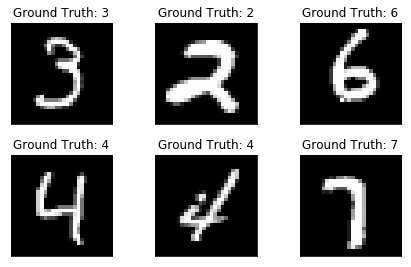

In [6]:
examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Now let's build the network. We will use a simple network, with three convolution layers, and two fully connected layers.

In [0]:
## build the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

We will use the CrossEntropyLoss as a loss because we are facing a classification task, and we will use the famous SGD optimizer to optimize the network.

In [0]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)

Let's define a helper method that will train the model

In [0]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since

    # load best model weights
    model.load_state_dict(best_model_wts)
    return best_acc.item()

In order to evaluate this method, we will train the same network several times, using the same hyperparameters, but only change the learning rate. First we will launch the learning rate finder method to find the optimal learning rate.

 89%|████████▉ | 89/100 [00:00<00:00, 91.63it/s]


LR Finder is complete. See the graph using `.plot()` method.
Min numerical gradient: 0.39810717055349676
Min loss: 0.7585775750291828


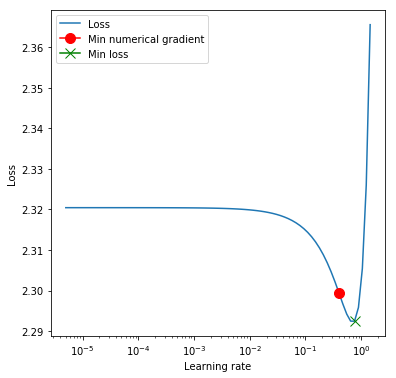

In [9]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.find(train_loader)
plt.figure(figsize=(6,6))
lr_finder.plot()

After observing the graph, and following the instructions mentioned above, we will choose the value 0.1 for the learning rate.
As a result, we will compare this value with other learning rate values which are 1e-4, 1e-3, 1e-2, 1 and 10. For each value, we will train the model 5 times, and we will record the average value of the accuracy obtained. The results will be summarized in a table below.

In [32]:
lrs = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]
repeat = 5
accs = defaultdict(list)
for lr in tqdm(lrs):
    for _ in range(repeat):
        model = Net().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        acc = train_model(model, criterion, optimizer, num_epochs=3)
        accs[lr].append(acc)


100%|██████████| 6/6 [16:18<00:00, 163.38s/it]


In [80]:
means = ["means"] + [np.mean(accs[lr]) for lr in lrs]
stds = ["stds"] + [np.std(accs[lr]) for lr in lrs]
print(tabulate([means, stds], headers=["lrs"] + lrs))

lrs       0.0001      0.001        0.01         0.1           1          10
-----  ---------  ---------  ----------  ----------  ----------  ----------
means  0.17946    0.74826    0.95522     0.98172     0.1073      0.10414
stds   0.0407632  0.0746226  0.00278381  0.00141619  0.00759342  0.00507685


Et Voila! as we can see, the learning rate suggested by lr_finder gives the best result.